# Humidity comparison with temp inputs between manometer temp and fitted tank temp
# Humidity in ppmv, Td and Td0

## 01_intialization

In [2]:
from datetime import datetime
import matplotlib.pyplot as plt
from safedigital import gas_pressure as GP
import pandas as pd
import numpy as np
import seaborn as sns
import pynverse as inv

sns.set(color_codes=True)
cur_dir = r'C:\Users\cnbofan1\ABB\Safe Digital in CN - Documents - Documents\06_Test and Analytics'

## 02_data splicing

In [10]:
test_date_list = ['20221009', '20221010', '20221011',
                  '20221012', '20221013']  # all test dates
test_id_list = ['_DTR_GP_SA12kV_SGCC_D=V_Bushing_Current_Drop',
                '_DTR_GP_SA12kV_SGCC_D=V_Bushing_Current_Variant',
                '_DTR_GP_SA12kV_SGCC_D=V_Bushing_Current_Variant',
                '_DTR_GP_SA12kV_SGCC_D=V_Bushing_630A',
                '_DTR_GP_12kV_SGCC_D=V_Bushing_700A']  # all test names

date_id_dict = {test_date_list[i]: test_id_list[i]
                for i in range(len(test_date_list))}
data_df_dict = {}

# load data in all dates save in a dict
for num, date in enumerate(test_date_list):
    data_path = (cur_dir + '\\' + date + date_id_dict[date] + '\\' +
                 '1_Data formatted' + '\\' + date + '_data_clean_1min.csv')
    data_df = pd.read_csv(data_path, header=0)
    data_df.index = [datetime.strptime(
        data_df.iloc[i, 0], '%Y-%m-%d %H:%M:%S') for i in range(len(data_df))]
    # print(data_df.dtypes)
    data_df_dict[date] = data_df
    if num == 0:
        data_all_df = data_df
    else:
        data_all_df = data_all_df.append(data_df)

# data in all dates
# temp from manometer in all dates
t_mano_all = data_all_df['Unit1_Mano_T'].values
# pressure from manometer in all dates
p_mano_all = data_all_df['Unit1_Mano_P'].values
t_tank_mid_all = data_all_df['t_V2_tank_mid'].values + data_all_df['t_oil_bottle_1'].values

# t_oil_bottle_2,t_oil_bottle_3,t_oil_bottle_4 values are temperature rise against t_oil_bottle_1
t_amb_all = (data_all_df['t_oil_bottle_4'].values +
             data_all_df['t_oil_bottle_3'].values +
             data_all_df['t_oil_bottle_2'].values +
             data_all_df['t_oil_bottle_1'].values * 4) / 4
t_ideal_all = p_mano_all / p_mano_all[0] * (t_mano_all[0] + 273.15) - 273.15
cur_phB_all = data_all_df['Unit1_B_Cur'].values


## 03_Gas temp comparison 

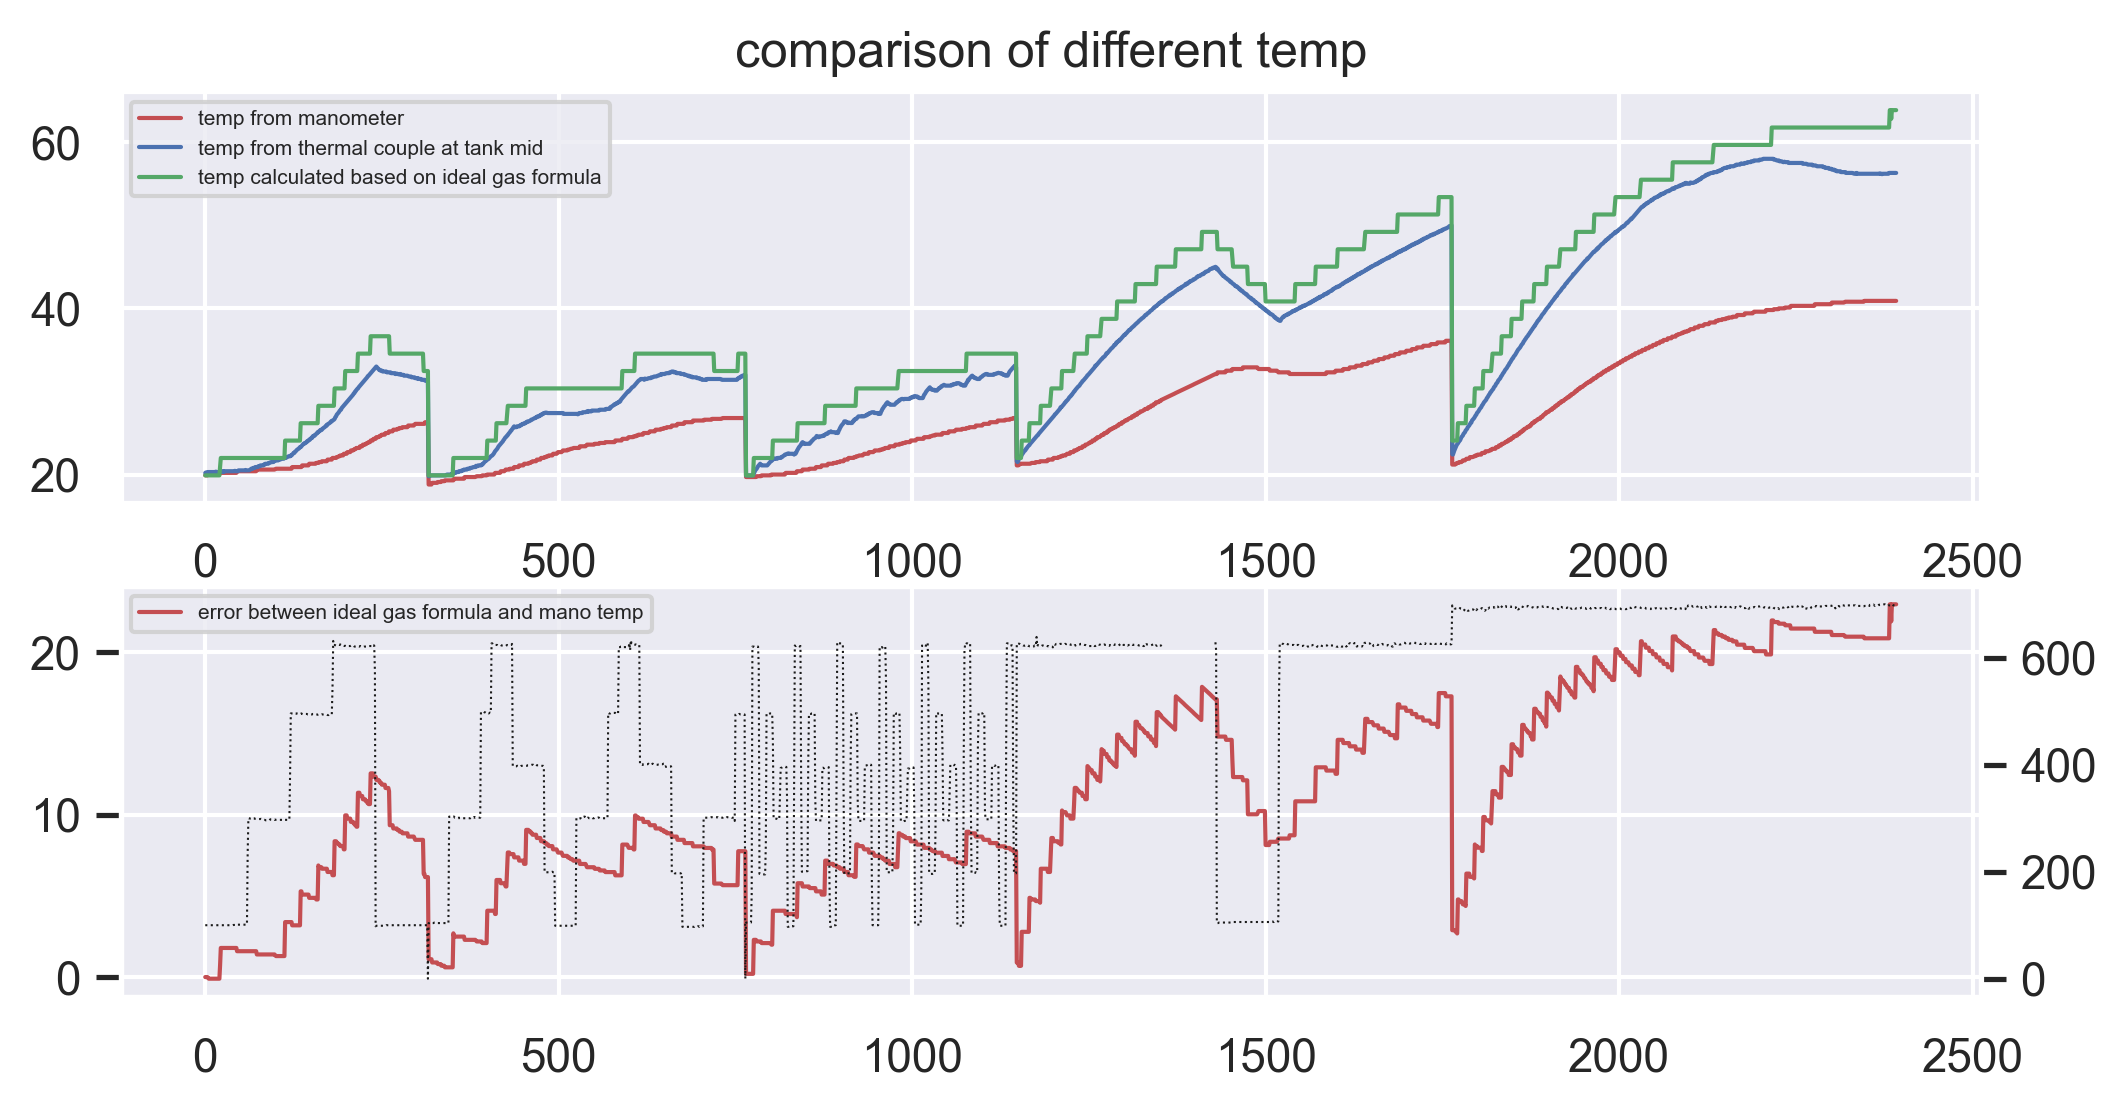

In [11]:

# compare mano temp, tank mid temp, ideal avg tank temp
plt.figure(figsize=(8, 4),
           dpi=300)
plt.subplot(2, 1, 1)
plt.plot(t_mano_all,
         c='r',
         linewidth=1,
         label='temp from manometer')
plt.plot(t_tank_mid_all,
         c='b',
         linewidth=1,
         label='temp from thermal couple at tank mid')
plt.plot(t_ideal_all,
         c='g',
         linewidth=1,
         label='temp calculated based on ideal gas formula')
plt.title('comparison of different temp')
plt.legend(fontsize=5)

plt.subplot(2, 1, 2)

plt.plot(t_ideal_all - t_mano_all,
         c='r',
         linewidth=1,
         label='error between ideal gas formula and mano temp')
plt.legend(fontsize=5)
ax1 = plt.gca()
ax2 = plt.twinx(ax1)
ax2.plot(cur_phB_all,
         c='k',
         linestyle='dotted',
         linewidth=0.5,
         label='current of phB')
plt.grid(None)

# plt.title('error of different temp')

## 04_Lanso vs Buck formular ew,ei

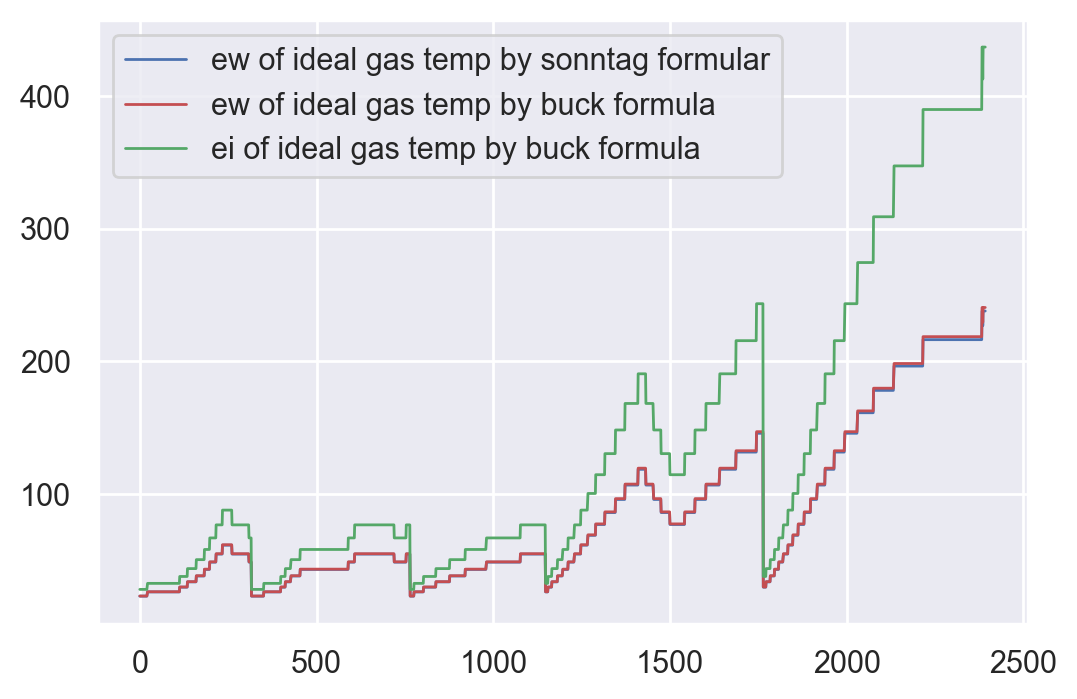

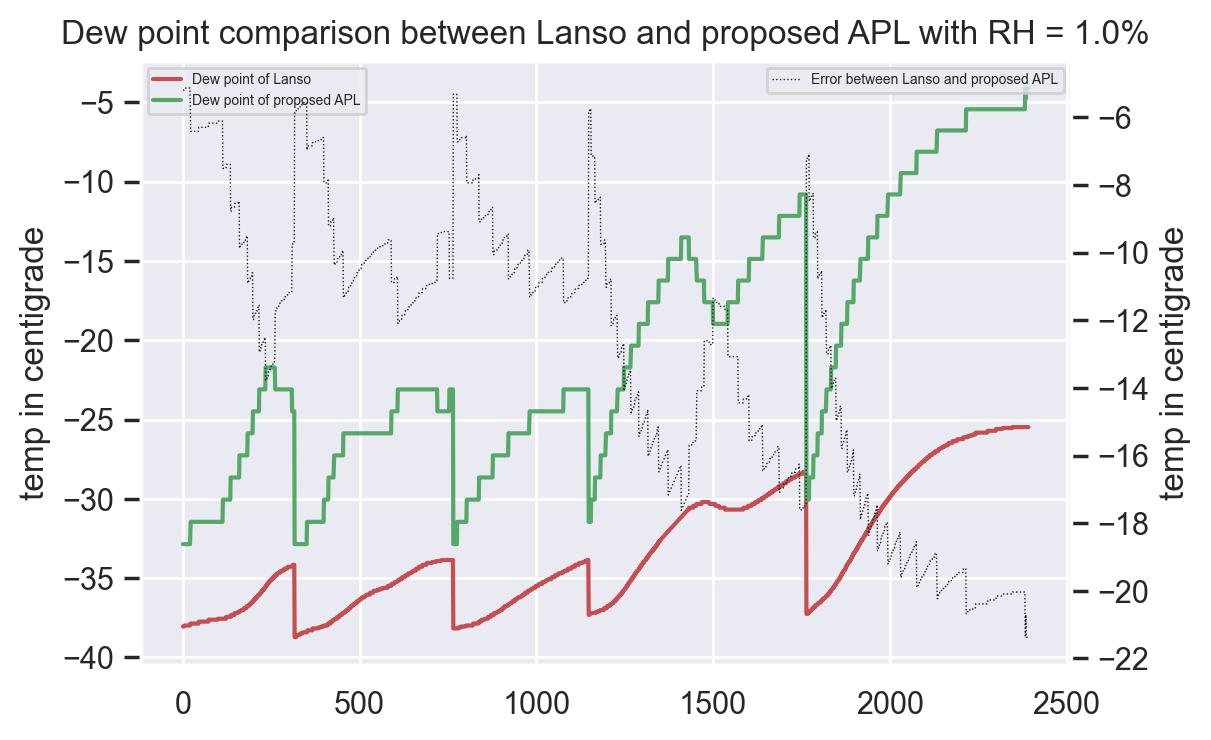

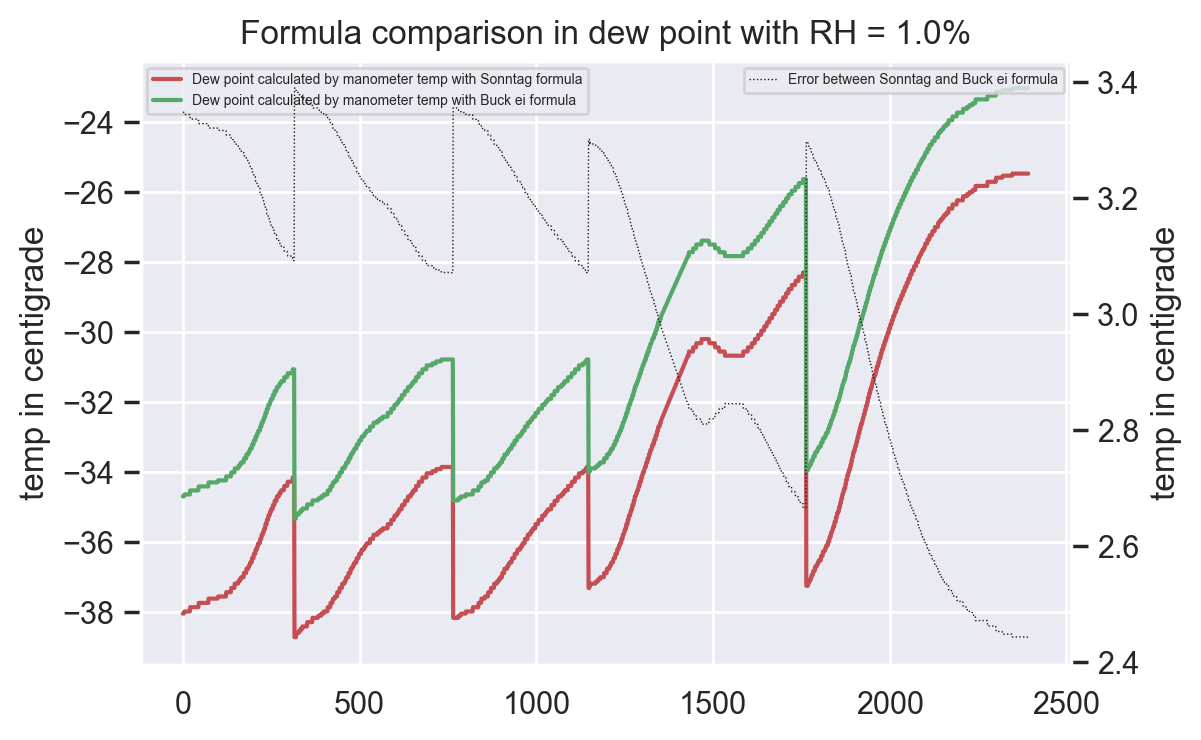

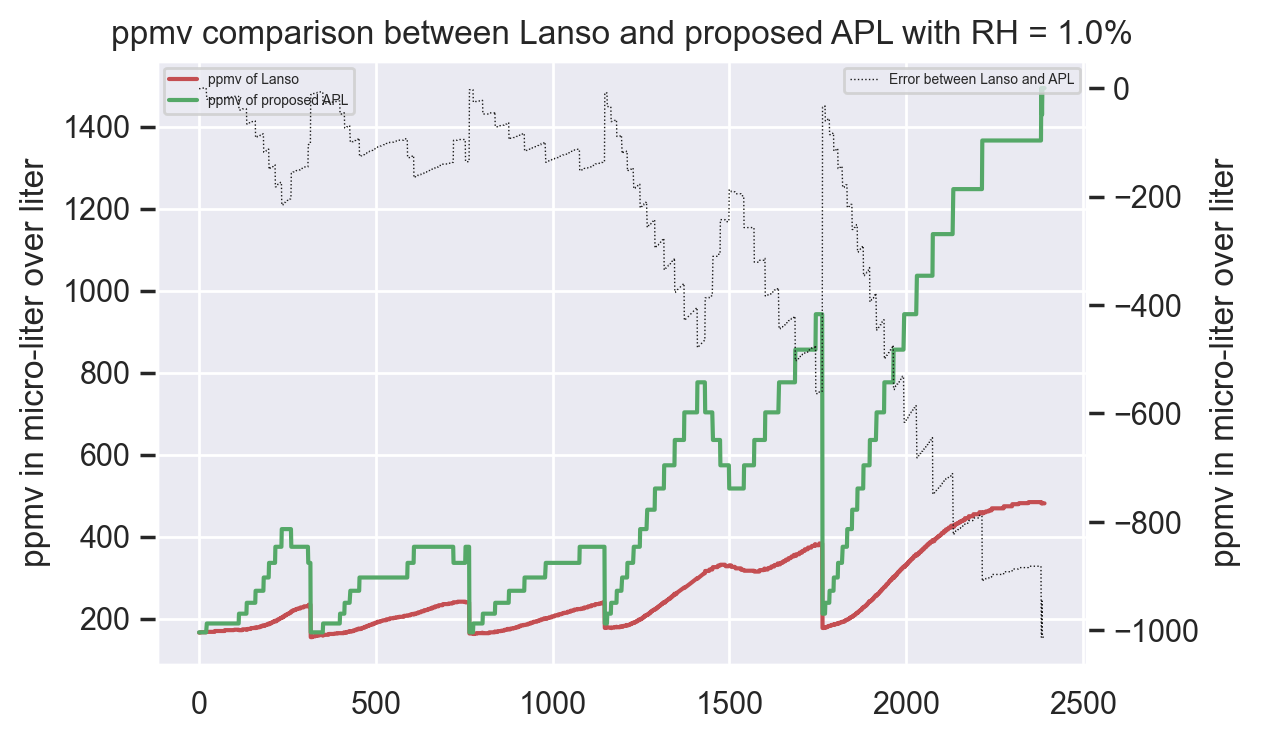

In [12]:
tc_mano = t_mano_all
tc_ideal = t_ideal_all
rh_arr = np.arange(0.01, 0.05, 0.01)
ew_mano_sonntag = [GP.GasPresExperiment_CN.cal_vapor_pressure(tc_mano[i], p_mano_all[i] * 1000, 'sonntag') for i in
                   range(len(tc_mano))]
ew_mano_buck = [GP.GasPresExperiment_CN.cal_vapor_pressure(tc_mano[i], p_mano_all[i] * 1000, 'buck_ew') for i in
                range(len(tc_mano))]
ei_mano_buck = [GP.GasPresExperiment_CN.cal_vapor_pressure(tc_mano[i], p_mano_all[i] * 1000, 'buck_ei') for i in
                range(len(tc_mano))]

ew_ideal_sonntag = [GP.GasPresExperiment_CN.cal_vapor_pressure(tc_ideal[i], p_mano_all[i] * 1000, 'sonntag') for i in
                    range(len(tc_mano))]
ew_ideal_buck = [GP.GasPresExperiment_CN.cal_vapor_pressure(tc_ideal[i], p_mano_all[i] * 1000, 'buck_ew') for i in
                 range(len(tc_mano))]
ei_ideal_buck = [GP.GasPresExperiment_CN.cal_vapor_pressure(tc_ideal[i], p_mano_all[i] * 1000, 'buck_ei') for i in
                 range(len(tc_mano))]

# plt.figure(dpi=200)
# plt.title('water vapor saturation pressure ei in mbar')
# plt.plot(ew_mano_sonntag, c='b', linestyle='dotted', label='ei of lanso by sonntag formula', linewidth=1)
# plt.plot(ew_mano_buck, c='r', linestyle='dotted', label='ew of lanso by buck formular', linewidth=1)
# plt.plot(ei_mano_buck, c='g', linestyle='dotted', label='ei of lanso by buck formular', linewidth=1)

plt.figure(dpi=200)
plt.plot(ew_ideal_sonntag, c='b', label='ew of ideal gas temp by sonntag formular', linewidth=1)
plt.plot(ew_ideal_buck, c='r', label='ew of ideal gas temp by buck formula', linewidth=1)
plt.plot(ei_ideal_buck, c='g', label='ei of ideal gas temp by buck formula', linewidth=1)
plt.legend()

for rh in rh_arr[0:1]:
    td_lanso_sonntag, td_lanso_buck, td_buck_ei, td_buck_ew, td_sonntag = np.zeros(
        shape=p_mano_all.shape), np.zeros(shape=p_mano_all.shape), np.zeros(shape=p_mano_all.shape), np.zeros(
        shape=p_mano_all.shape), np.zeros(shape=p_mano_all.shape)
    ppmv_lanso, ppmv_buck = np.zeros(
        shape=p_mano_all.shape), np.zeros(shape=p_mano_all.shape)
    for idx, p_bar in enumerate(p_mano_all):
        ppmv_lanso[idx] = ew_mano_sonntag[idx] * rh / (p_bar * 1e3 - ew_mano_sonntag[idx] * rh) * 1e6
        ppmv_buck[idx] = ew_ideal_buck[idx] * rh / (p_bar * 1e3) * 1e6
        sonntag_func = (lambda x: np.exp(-6096.9385 / (x + 273.15) +
                                         16.635794 -
                                         2.711193 * 10 ** (-2) * (x + 273.15) +
                                         1.673952 * 10 ** (-5) * (x + 273.15) ** 2 +
                                         2.433502 * np.log(x + 273.15)))  # mbar
        sonntag_inv = inv.inversefunc(sonntag_func)

        buck_ei_func = (lambda x: (1.0003 + 4.18 * 1e-6 * p_bar * 1e3) *
                                  6.1115 * np.exp((22.452 * x) / (272.55 + x)))
        buck_ew_func = (lambda x: (1.0007 + 3.46 * 1e-6 * p_bar * 1e3) *
                                  6.1121 * np.exp((17.502 * x) / (240.97 + x)))
        # buck_no_P_func = (lambda x: 6.1115 * np.exp((22.452 * x) / (272.55 + x)))
        buck_ei_inv = inv.inversefunc(buck_ei_func)
        buck_ew_inv = inv.inversefunc(buck_ew_func)
        # buck_no_P_inv = inv.inversefunc(buck_no_P_func)
        td_lanso_sonntag[idx] = sonntag_inv(ew_mano_sonntag[idx] * rh)
        td_lanso_buck[idx] = buck_ei_inv(ew_mano_sonntag[idx] * rh)
        td_sonntag[idx] = sonntag_inv(ew_ideal_sonntag[idx] * rh)
        td_buck_ew[idx] = buck_ei_inv(ew_ideal_buck[idx] * rh)
        td_buck_ei[idx] = buck_ei_inv(ei_ideal_buck[idx] * rh)
    # print('{:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(ew_mano_sonntag[idx], ei_ideal_buck[idx], tc_mano[idx], tc_ideal[idx], td_lanso[idx], td_buck[idx]))

    plt.figure(dpi=200)
    plt.title('Dew point comparison between Lanso and proposed APL with RH = {:.1f}%'.format(rh * 100))
    plt.plot(td_lanso_sonntag, c='r', label='Dew point of Lanso')
    plt.plot(td_buck_ei, c='g', label='Dew point of proposed APL')
    plt.ylabel('temp in centigrade')
    plt.legend(fontsize=5)
    ax1 = plt.gca()
    ax2 = plt.twinx(ax1)
    plt.plot(td_lanso_sonntag - td_buck_ei, c='k', linestyle='dotted', linewidth=0.5,
             label='Error between Lanso and proposed APL')
    plt.grid(None)
    plt.legend(fontsize=5)
    plt.ylabel('temp in centigrade')

    plt.figure(dpi=200)
    plt.title('Formula comparison in dew point with RH = {:.1f}%'.format(rh * 100))
    plt.plot(td_lanso_sonntag, c='r', label='Dew point calculated by manometer temp with Sonntag formula')
    plt.plot(td_lanso_buck, c='g', label='Dew point calculated by manometer temp with Buck ei formula')
    plt.ylabel('temp in centigrade')
    plt.legend(fontsize=5)

    ax1 = plt.gca()
    ax2 = plt.twinx(ax1)
    plt.plot(td_lanso_buck - td_lanso_sonntag, c='k', linestyle='dotted', linewidth=0.5,
             label='Error between Sonntag and Buck ei formula')
    plt.ylabel('temp in centigrade')
    plt.grid(None)
    plt.legend(fontsize=5)

    plt.figure(dpi=200)
    plt.title('ppmv comparison between Lanso and proposed APL with RH = {:.1f}%'.format(rh * 100))
    plt.plot(ppmv_lanso, c='r', label='ppmv of Lanso')
    plt.plot(ppmv_buck, c='g', label='ppmv of proposed APL')
    plt.legend(fontsize=5)
    plt.ylabel('ppmv in micro-liter over liter')
    ax1 = plt.gca()
    ax2 = plt.twinx(ax1)
    plt.plot(ppmv_lanso - ppmv_buck, c='k', linestyle='dotted', linewidth=0.5,
             label='Error between Lanso and APL')
    plt.ylabel('ppmv in micro-liter over liter')
    plt.grid(None)
    plt.legend(fontsize=5)


## 05_calculation verification of different formula

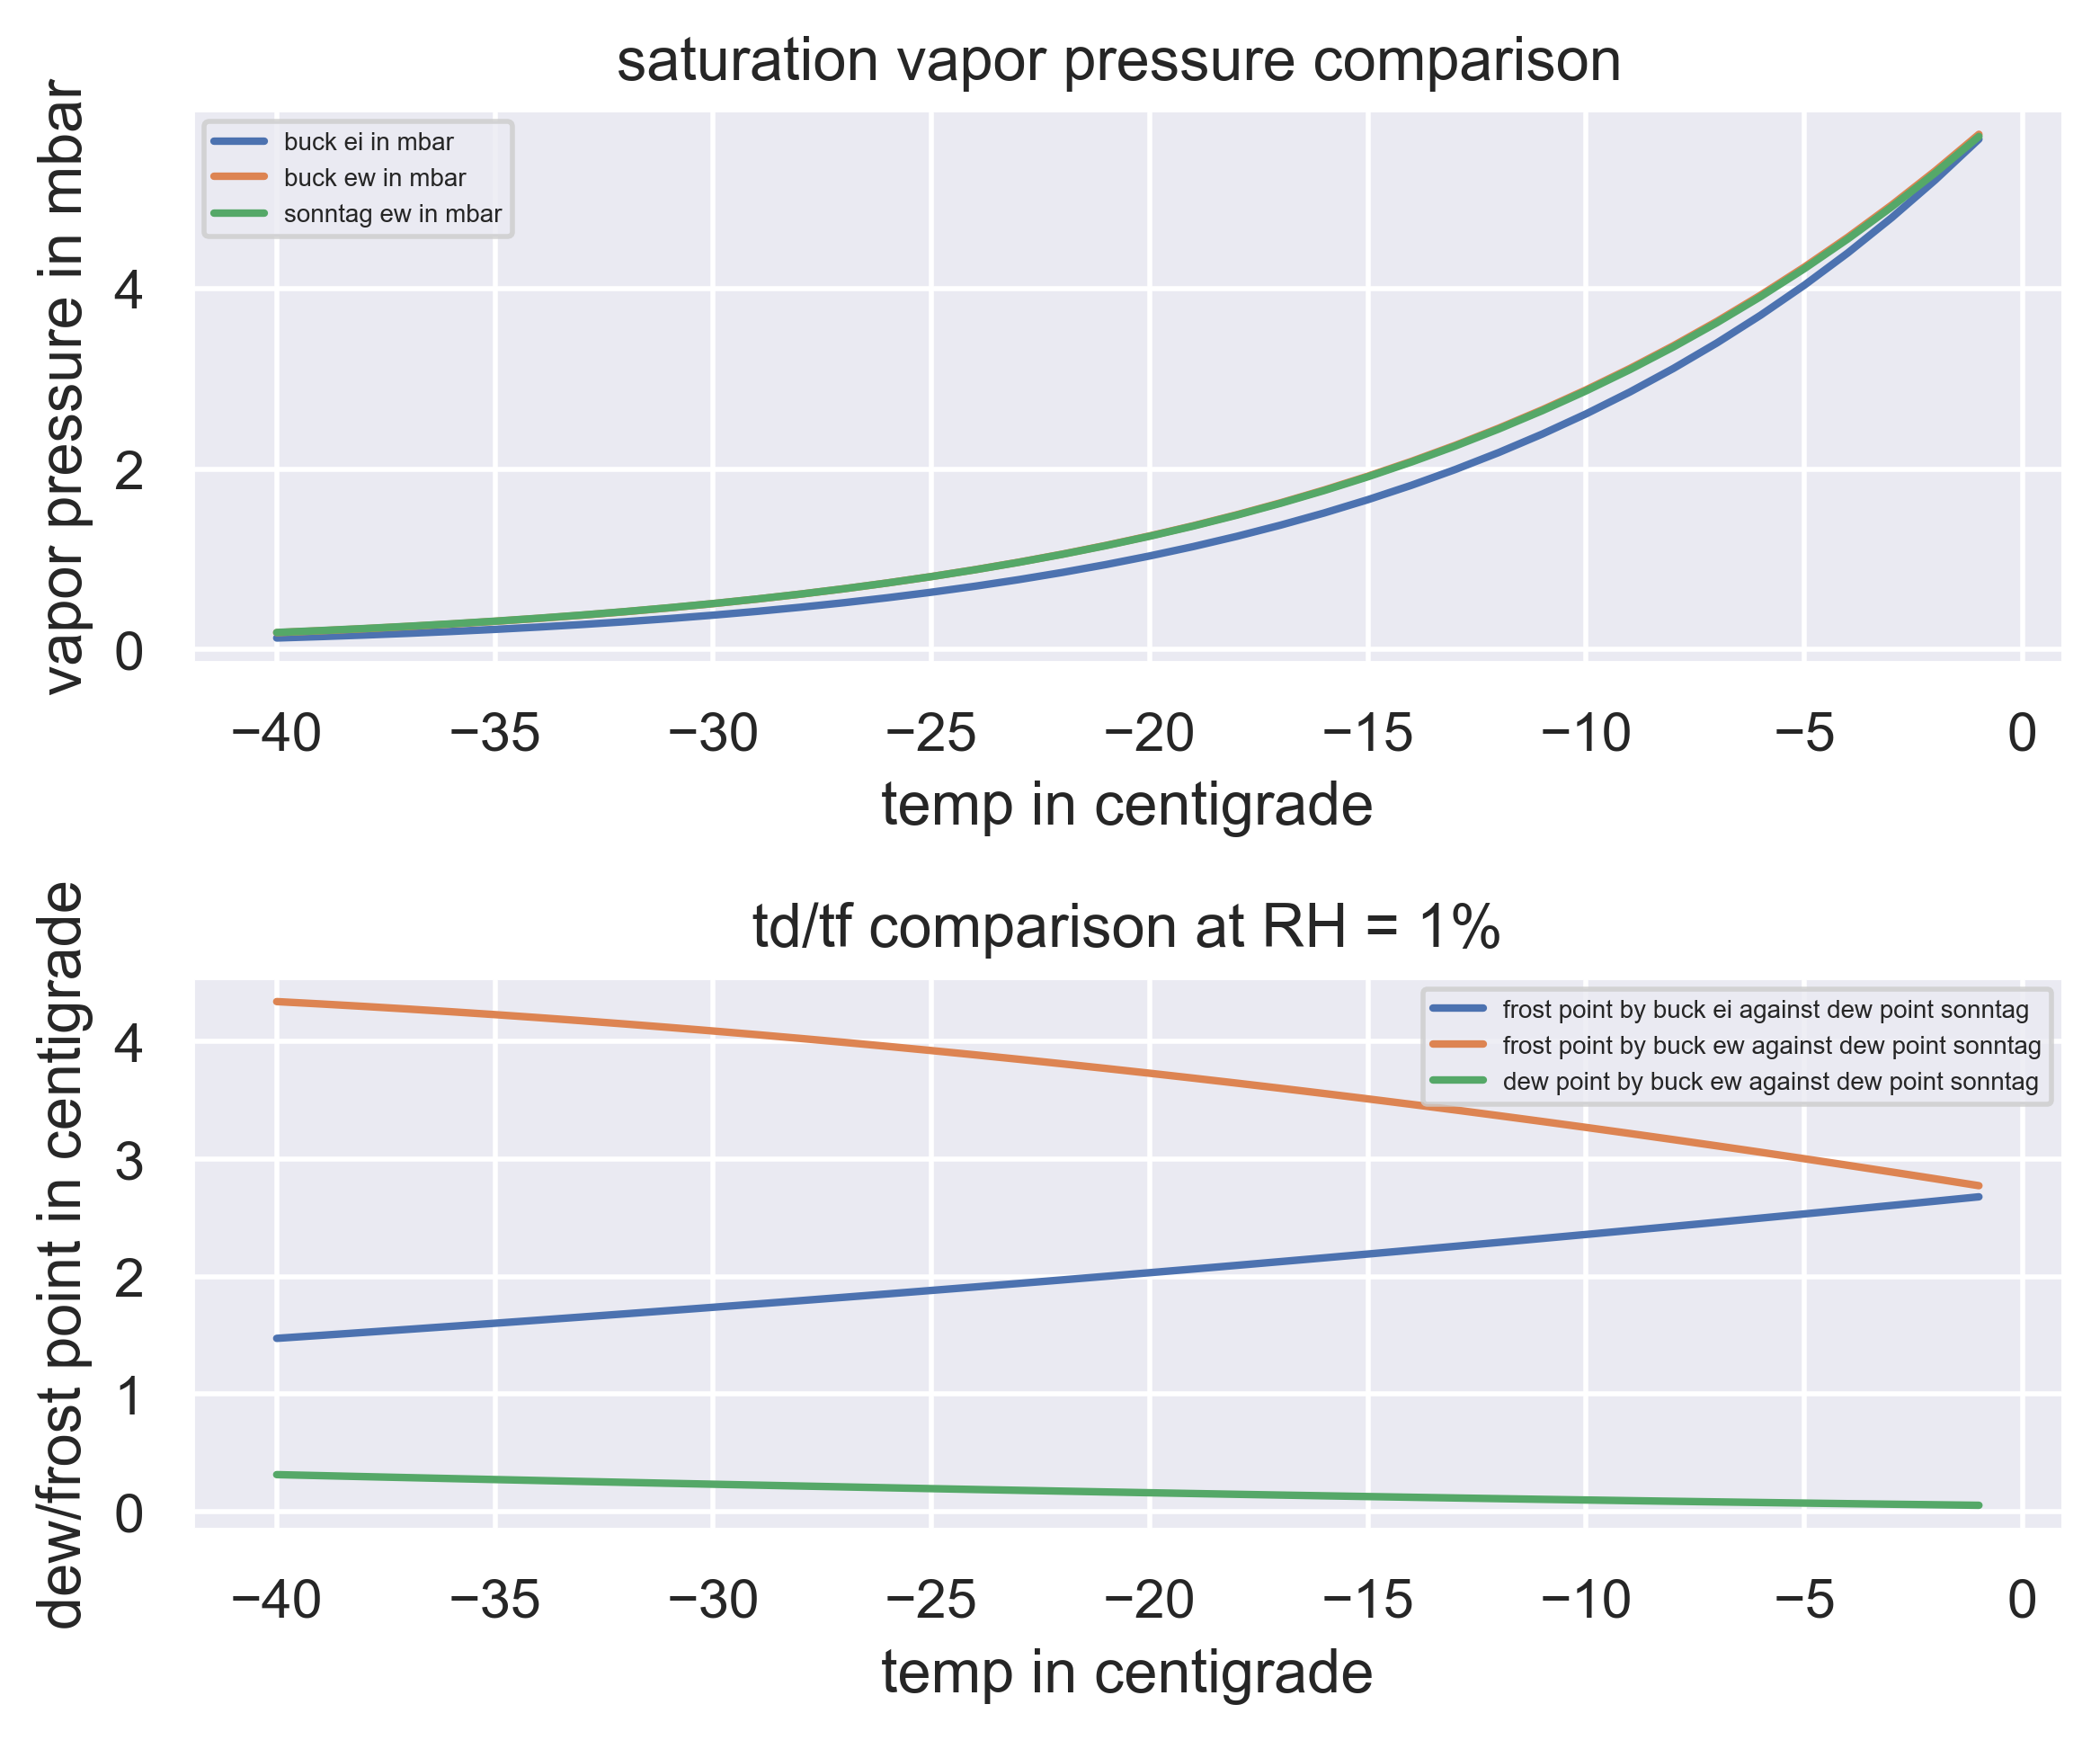

In [21]:
buck_ei_func = (lambda x: (1.0003 + 4.18 * 1e-6 * 1.0 * 1e3) *
                          6.1115 * np.exp((22.452 * x) / (272.55 + x)))
buck_ew_func = (lambda x: (1.0007 + 3.46 * 1e-6 * 1.0 * 1e3) *
                          6.1121 * np.exp((17.502 * x) / (240.97 + x)))
sonntag_func = (lambda x: np.exp(-6096.9385 / (x + 273.15) +
                                 16.635794 -
                                 2.711193 * 10 ** (-2) * (x + 273.15) +
                                 1.673952 * 10 ** (-5) * (x + 273.15) ** 2 +
                                 2.433502 * np.log(x + 273.15)))  # mbar
buck_ei_inv = inv.inversefunc(buck_ei_func)
buck_ew_inv = inv.inversefunc(buck_ew_func)
sonntag_inv = inv.inversefunc(sonntag_func)
t_arr = np.arange(-40, 0, 1)
ei_buck, ew_sonntag, ew_buck = np.zeros(shape=t_arr.shape), np.zeros(
    shape=t_arr.shape), np.zeros(shape=t_arr.shape)
t_frost_buck, t_dew_sonntag, t_dew_buck, t_frost_buck_ew = np.zeros(shape=t_arr.shape), np.zeros(
    shape=t_arr.shape), np.zeros(shape=t_arr.shape), np.zeros(shape=t_arr.shape)
rh = 0.1
for idx, t in enumerate(t_arr):
    ei_buck[idx] = buck_ei_func(t)
    ew_sonntag[idx] = sonntag_func(t)
    ew_buck[idx] = buck_ew_func(t)
    t_frost_buck[idx] = buck_ei_inv(rh * buck_ei_func(t))
    t_frost_buck_ew[idx] = buck_ei_inv(rh * buck_ew_func(t))
    t_dew_sonntag[idx] = sonntag_inv(rh * sonntag_func(t))
    t_dew_buck[idx] = buck_ew_inv(rh * buck_ew_func(t))
    # t_inv_buck[idx] = buck_inv_tmp(ei_buck[idx])
    # t_inv_sonntag[idx] = sonntag_inv(ew_sonntag[idx])

plt.figure(figsize=(6, 5), dpi=400)
plt.subplot(2, 1, 1)
plt.title('saturation vapor pressure comparison ')
plt.plot(t_arr,
         ei_buck,
         label='buck ei in mbar')
plt.plot(t_arr,
         ew_buck,
         label='buck ew in mbar')
plt.plot(t_arr,
         ew_sonntag,
         label='sonntag ew in mbar')
plt.xlabel('temp in centigrade')
plt.ylabel('vapor pressure in mbar')
plt.legend(fontsize=5)

# t_arr = np.arange(0, 60, 1)
# for idx, t in enumerate(t_arr):
#     ei_buck[idx] = buck_ei_func(t)
#     ew_sonntag[idx] = sonntag_func(t)
#     ew_buck[idx] = buck_ew_func(t)
#     # t_inv_buck[idx] = buck_inv_tmp(ei_buck[idx])
#     # t_inv_sonntag[idx] = sonntag_inv(ew_sonntag[idx])
# plt.subplot(2,1,2)
# plt.title('(0C,60C) saturation pressure comparison refering to buck ew')
# plt.plot(t_arr,
#          (ei_buck - ew_buck) / ew_buck * 100,
#          label='percentage deviation buck ei from buck ew')
# plt.plot(t_arr,
#          (ew_sonntag - ew_buck) / ew_buck * 100,
#          label='percentage deviation sonntag ew from buck ew')
# plt.legend(fontsize=5)
# plt.tight_layout()

plt.subplot(2, 1, 2)
plt.title(' td/tf comparison at RH = 1% ')
plt.plot(t_arr,
         t_frost_buck - t_dew_sonntag,
         label='frost point by buck ei against dew point sonntag ')
plt.plot(t_arr,
         t_frost_buck_ew - t_dew_sonntag,
         label='frost point by buck ew against dew point sonntag')
plt.plot(t_arr,
         t_dew_buck - t_dew_sonntag,
         label='dew point by buck ew against dew point sonntag')
plt.xlabel('temp in centigrade')
plt.ylabel('dew/frost point in centigrade')
plt.legend(fontsize=5)
plt.tight_layout()

## 06_Calculation for constant Td_warning and Td_alarm when -20℃ ≥ Tamb ≥ -40℃

In [23]:
T20_ppmv = 1000
ei = T20_ppmv * 1400 * 1e-6  # mbar
t_avg = 13
buck_ew_func = (lambda x: (1.0007 + 3.46 * 1e-6 * 1.4 * 1e3) *
                          6.1121 * np.exp((17.502 * x) / (240.97 + x)))
buck_ei_func = (lambda x: (1.0003 + 4.18 * 1e-6 * 1.4 * 1e3) *
                          6.1115 * np.exp((22.452 * x) / (272.55 + x)))

buck_ei_inv = inv.inversefunc(buck_ei_func)
# print('td @ 1000ppmv and 1.4 bar : ', buck_ei_inv(ei))
es = buck_ew_func(13)
rh = 0.01
tdew = buck_ei_inv(es * rh)
print(tdew)

-38.64817250269619


## 07_Calculated Dew points - T_dew vs T_avg - Calculated ideal gas tank average temp
### given RH = 1%, P = 1.4 bar

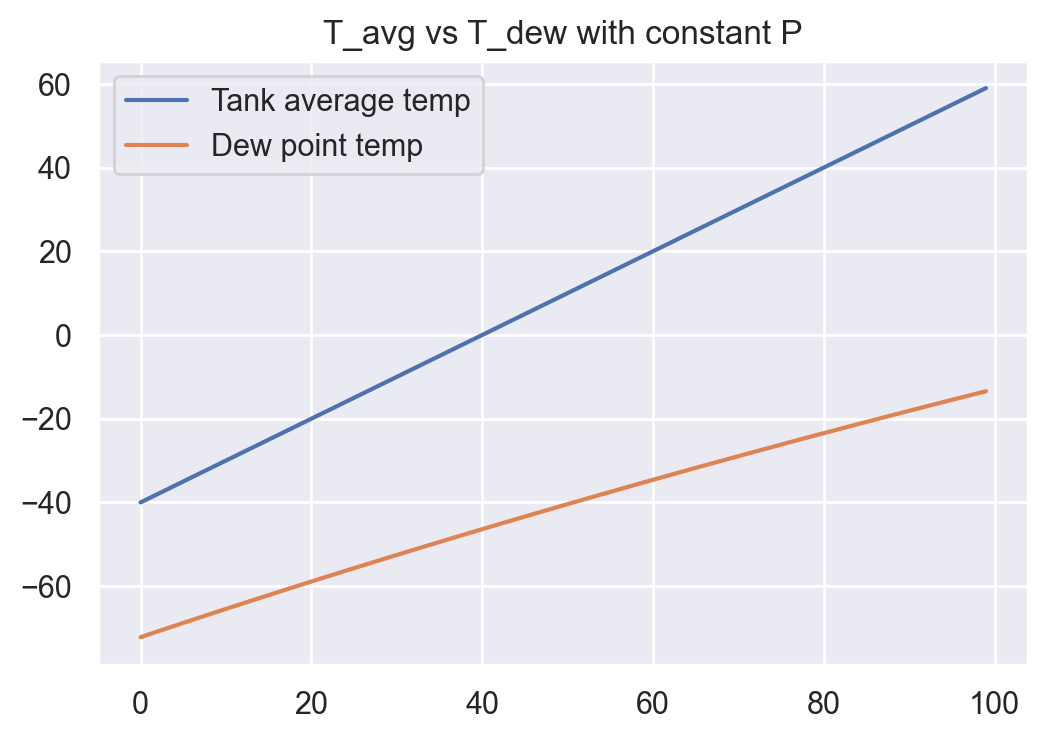

In [21]:
RH = 0.01
buck_ew_func = (lambda x: (1.0007 + 3.46 * 1e-6 * 1.4 * 1e3) *
                          6.1121 * np.exp((17.502 * x) / (240.97 + x)))
buck_ei_func = (lambda x: (1.0003 + 4.18 * 1e-6 * 1.4 * 1e3) *
                          6.1115 * np.exp((22.452 * x) / (272.55 + x)))
buck_ei_inv = inv.inversefunc(buck_ei_func)
T_avg = np.arange(-40, 60)
ew = np.array([buck_ew_func(i) for i in T_avg])
es = RH * ew
T_dew = np.array([buck_ei_inv(i) for i in es])
plt.figure(dpi=200)
# plt.plot(T_avg, T_dew)
plt.plot(T_avg, label='Tank average temp')
plt.plot(T_dew, label='Dew point temp')
plt.legend()
plt.title('T_avg vs T_dew with constant P')
df = pd.DataFrame({'T_avg': T_avg, 'T_dew': T_dew})
df.to_csv(
    'C:\\Users\\cnbofan1\\ABB\\Safe Digital in CN - Documents - Documents\\04_Designs\\9_Gas Quality\\05_Figures\\T_avg_vs_T_dew_constant_P.csv')

### given RH = 1%, initial P20 = 1.4 bar, not leakage was assumed

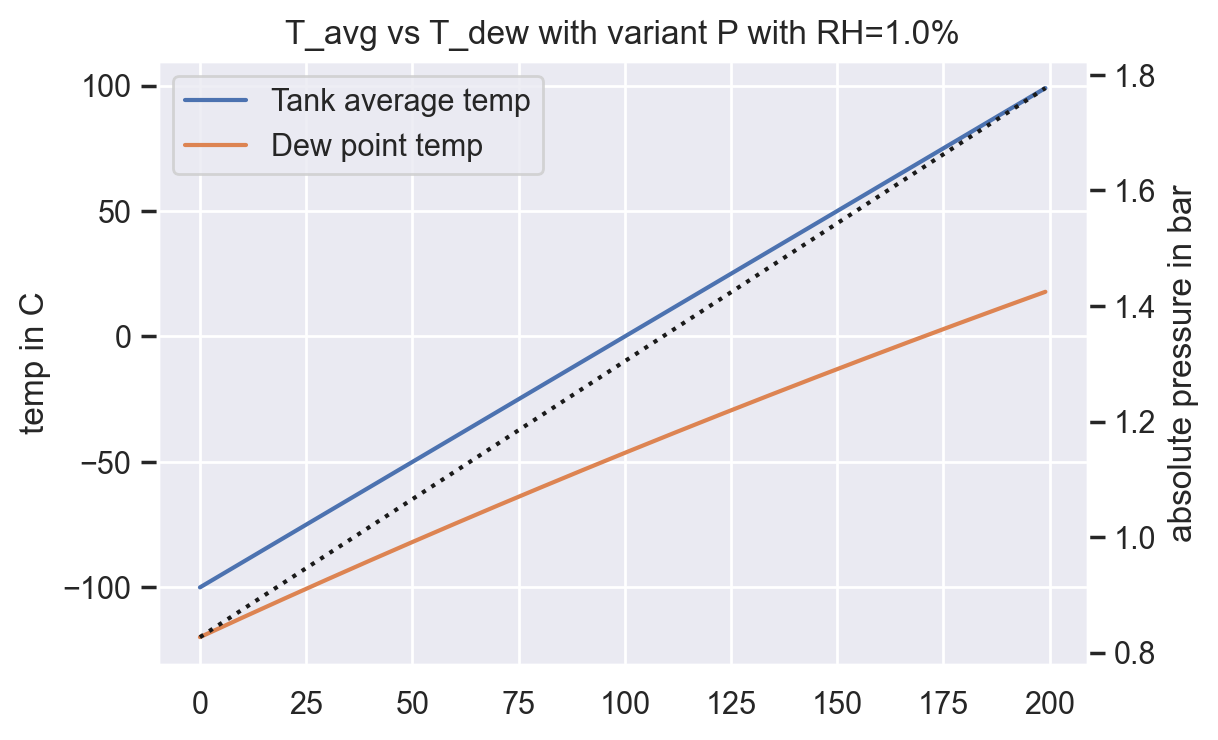

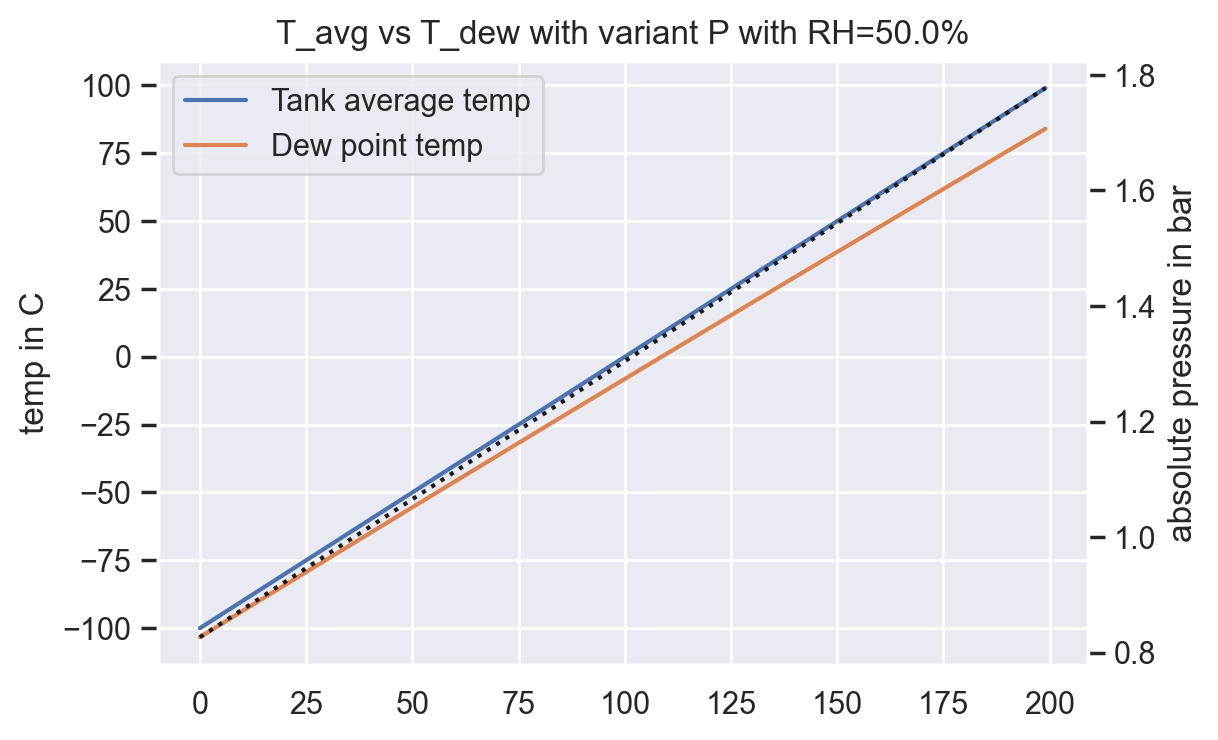

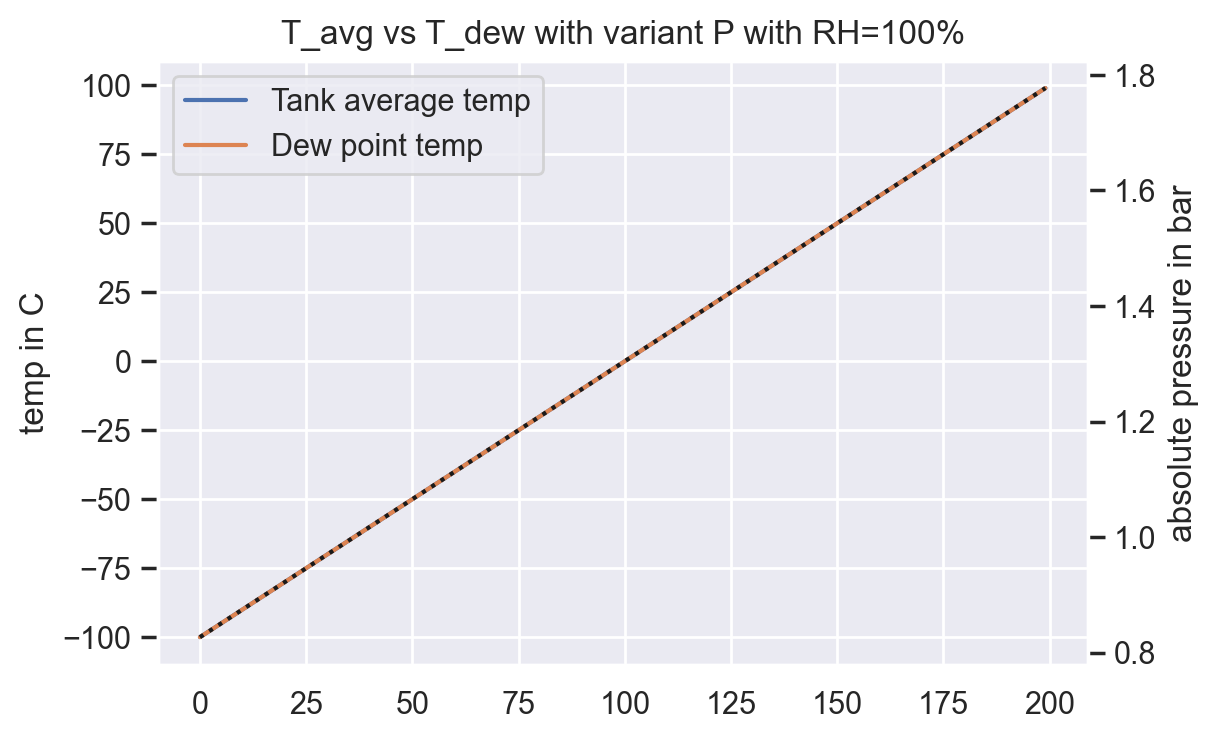

In [35]:
for RH in [0.01, 0.5, 1]:
    T_avg = np.arange(-100, 100)
    P = np.array([(i + 273.15) * 1.4 / 293.15 for i in T_avg])
    ew, es, T_dew = np.zeros(shape=T_avg.shape, dtype=float), np.zeros(shape=T_avg.shape, dtype=float), np.zeros(
        shape=T_avg.shape, dtype=float)
    for ix, val in enumerate(P):
        buck_ew_func = (lambda x: (1.0007 + 3.46 * 1e-6 * val * 1e3) *
                                  6.1121 * np.exp((17.502 * x) / (240.97 + x)))
        buck_ei_func = (lambda x: (1.0003 + 4.18 * 1e-6 * val * 1e3) *
                                  6.1115 * np.exp((22.452 * x) / (272.55 + x)))
        buck_ei_inv = inv.inversefunc(buck_ei_func)
        ew[ix] = buck_ei_func(T_avg[ix])
        es[ix] = RH * ew[ix]
        T_dew[ix] = buck_ei_inv(es[ix])
    plt.figure(dpi=200)
    plt.plot(T_avg, label='Tank average temp')
    plt.plot(T_dew, label='Dew point temp')
    plt.ylabel('temp in C')
    plt.legend()
    ax = plt.gca()
    ax2 = plt.twinx(ax)
    plt.sca(ax2)
    plt.plot(P, label='absolute pressure', c='k', linestyle='dotted')
    plt.ylabel('absolute pressure in bar')
    plt.grid(None)
    plt.title('T_avg vs T_dew with variant P with RH={}%'.format(RH * 100))
    df = pd.DataFrame({'T_avg': T_avg, 'T_dew': T_dew, 'P': P})
    df.to_csv(
        'C:\\Users\\cnbofan1\\ABB\\Safe Digital in CN - Documents - Documents\\04_Designs\\9_Gas Quality\\05_Figures\\T_avg_vs_T_dew_variant_P_RH={}.csv'.format(
            RH))

### ppmv = 1000

In [39]:
buck_ew_func = (lambda x: (1.0007 + 3.46 * 1e-6 * 1.4 * 1e3) *
                          6.1121 * np.exp((17.502 * x) / (240.97 + x)))
buck_ei_func = (lambda x: (1.0003 + 4.18 * 1e-6 * 1.4 * 1e3) *
                          6.1115 * np.exp((22.452 * x) / (272.55 + x)))
t_avg = 20
ew = buck_ew_func(t_avg)
print('ew=', ew)
ppmv = 1000
es = 1400 * ppmv / 1e6
RH = es / ew
print('RH=', RH)


ew= 23.50240366880742
RH= 0.059568375206579025


## 08_If RH,PPMV of Manometer = Gas Tanks

In [3]:
sonntag_func = (lambda x: np.exp(-6096.9385 / (x + 273.15) +
                                 16.635794 - 2.711193 * 10 ** (-2) * (x + 273.15) +
                                 1.673952 * 10 ** (-5) * (x + 273.15) ** 2 +
                                 2.433502 * np.log(x + 273.15)))
t1 = np.arange(-10, 10)
pws = sonntag_func(t1)
rh = 0.01
pw = pws * rh